# Measuring Kinetic Energy of Coupled Classical Harmonic Oscillator Systems using Classiq
Authors: Viraj Dsouza, Cristina Radian, Kerem Yurtseven

Date: 09.08.2024

This work is designed under and for the final project of the Womanium Quantum+AI Program 2024

Reference Paper: Exponential Quantum Speedup in Simulating Coupled Classical Oscillators, Babbush et.al, 2023 [1](https://arxiv.org/abs/2303.13012)
___

## Optimization

In this notebook, we aim to optimize circuit and estimate circuit width, depth, number of 2-qubit gates in IBM Quantum Computers.

___


## Our Configuration

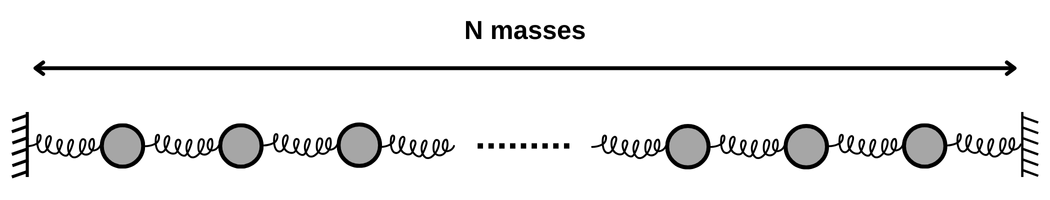

We use $N = 2^3$ masses and evolve it for a certain time. All masses are equal to 1, i.e $m_i = 1$. Also, the spring between each adjacent mass is 1 and initial and final masses are connected to the wall with a spring constant equal to 1. Initial states are chosen as $\vec{x}(t) = (0,0,0,0.....0)^T$ and $\vec{\dot{x}}(t) = (1,0,0,0.....0)^T$

In the post-processing, we get the final velocity vector and evalueate $\hat{k_V}(t)$ as
\begin{equation*}
    \hat{k_V}(t) = \frac{v(t)^T v(t)}{2}
    \qquad(3)
\end{equation*}

___

## Pre-Processing

Create necessary matrix and initial states using functions created in `ccho_helpers.py`

In [1]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
from ccho_helpers import *
from classiq import (
    qfunc,
    QNum,
    QArray,
    QBit,
    CArray,
    CReal,
    CInt,
    QCallable,
    allocate,
    bind,
    repeat,
    CX,
    control,
    PHASE,
    Output,
    prepare_amplitudes,
    create_model,
    set_execution_preferences,
    synthesize,
    execute,
    suzuki_trotter,
    exponentiation_with_depth_constraint,
    show,
    Constraints,
    set_constraints,
    switch,
    PauliTerm,
    Pauli,
    within_apply,
    inplace_prepare_state,
    IDENTITY, X, Y, Z,
    reflect_about_zero,
    RY, U, power,
    write_qmod,
    QuantumProgram,
    OptimizationParameter
)
from classiq.execution import ExecutionPreferences, ClassiqBackendPreferences, IBMBackendPreferences, IBMBackendProvider

In [2]:
## Providing all inputs for 8 coupled SHO case and performing all the initial transformations

# Number of masses
N=2**3

# Mass Matrix
M= np.zeros([N, N])
for i in range(N):
    M[i][i] = 1

K = np.zeros([N,N])
for j in range(N):
    for t in range(j, N):
        if j == 0 or j == N-1:
            K[j][j] = 1
        if abs(j-t) == 1:
            K[j][t] = 1
            K[t][j] = 1

# Initial Conditions
x_0 = np.zeros([N,1])
xdot_0 = np.zeros([N,1])
xdot_0[0] = 1

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
H = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)
E0_y = calculate_energy(y_0, ydot_0, M, K)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("Initial Energy: ", E0_y)
print("B matrix: ", B)
print("Hamiltonian formed:", H)
print("Initial State:", init_state)

Initial Energy:  0.5
B matrix:  [[ 1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  1.+0.j  0.+0.j
   

## Pauli Matrix Decomposition

Create the Pauli List for the Hamiltonian. Pauli Decomposition is taken from [Classiq Library](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb) thanks a lot to the authors!

In [3]:
## Pauli Decomposition and transforming it into Classiq syntax

# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(H)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

100%|██████████| 16384/16384 [00:10<00:00, 1612.71it/s]

[('XIIIIIZ', (-0.03125+0j)), ('XIIIIZZ', (-0.03125+0j)), ('XIIIIZX', (-0.03125+0j)), ('XIIIIXI', (-0.015625+0j)), ('XIIIIXZ', (0.015625+0j)), ('XIIIIXX', (0.015625+0j)), ('XIIIIYY', (-0.015625+0j)), ('XIIIZIZ', (-0.03125+0j)), ('XIIIZZZ', (-0.03125+0j)), ('XIIIZZX', (-0.03125+0j)), ('XIIIZXI', (-0.015625+0j)), ('XIIIZXZ', (0.015625+0j)), ('XIIIZXX', (-0.015625+0j)), ('XIIIZYY', (0.015625+0j)), ('XIIIXII', (-0.015625+0j)), ('XIIIXIZ', (0.015625+0j)), ('XIIIXZI', (0.015625+0j)), ('XIIIXZZ', (-0.015625+0j)), ('XIIIXXI', (0.015625+0j)), ('XIIIXXZ', (-0.015625+0j)), ('XIIIXXX', (-0.015625+0j)), ('XIIIXYY', (-0.015625+0j)), ('XIIIYXY', (0.015625+0j)), ('XIIIYYI', (0.015625+0j)), ('XIIIYYZ', (-0.015625+0j)), ('XIIIYYX', (-0.015625+0j)), ('XIIZIIZ', (-0.03125+0j)), ('XIIZIZZ', (-0.03125+0j)), ('XIIZIZX', (-0.03125+0j)), ('XIIZIXI', (-0.015625+0j)), ('XIIZIXZ', (0.015625+0j)), ('XIIZIXX', (0.015625+0j)), ('XIIZIYY', (-0.015625+0j)), ('XIIZZIZ', (-0.03125+0j)), ('XIIZZZZ', (-0.03125+0j)), ('XIIZ

## Hamiltonian simulation

We use the `suzuki_trotter` function of classiq that produces a quantum gate that approximates $e^{iHt}$, for any input **Hermitian operator** $H$. Since the Hamiltonian for this algorithm is Hermitian by definition, exponentiation methods can be used straightforwardly.

In [4]:
## Create qfuncs

# Add i phase for the last half
@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(np.pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)

# Main function with suzuki_trotter
@qfunc
def main(state: Output[QNum]):
    """
        Definition:
            Main function to make evolution

        Outputs:
            state (Output[QNum]): Resulting state at the t = evolution_coefficient
    """
        
    prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.00000000000001)
    init_state_phase(state)

    suzuki_trotter(
        classiq_pauli_list,
        evolution_coefficient=t,
        order=2,
        repetitions=10,
        qbv=state,
    )


In [5]:

# Create model and synthesis. Use "simulator_statevector" to take phases into account
qmod = create_model(main)
#write_qmod(qmod, "KineticEnergyEstimation", decimal_precision=16)

In [7]:
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1, backend_preferences=backend_preferences))
qprog = synthesize(model_pref)
show(qprog)

Opening: https://platform.classiq.io/circuit/f48d936d-ee26-4f81-816f-425a6b942bbf?version=0.43.3


In [8]:
print("Classiq Simulator Synthesis")
syn_time = (QuantumProgram.parse_raw(qprog).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog).synthesis_duration.solving + QuantumProgram.parse_raw(qprog).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog).synthesis_duration.postprocessing)

transp_depth = QuantumProgram.parse_raw(qprog).transpiled_circuit.depth
transp_width = QuantumProgram.parse_raw(qprog).data.width
transp_cx = QuantumProgram.parse_raw(qprog).transpiled_circuit.count_ops["cx"]

print("Synthesis Time            : ", syn_time, "s")

print("Transpiled Circuit Depth  : ", transp_depth)
print("Transpiled Circuit Width  : ", transp_width)
print("Transpiled Circuit CX Gate: ", transp_cx)

Classiq Simulator Synthesis
Synthesis Time            :  37.86787368200021 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561


In [9]:
## Define Hardware preferences and synthesize

qmod = create_model(main)
ibm_kyoto = IBMBackendPreferences(
    backend_name="ibm_kyoto",
    access_token="a413d92dafb1771ea3806b66493a2c5dfe195241eb753016f9fcd8d46ec80aeca1b6286cf9fa4d4c0f1f2420a7496c191fe0dd675e3cf5644142b95182964a63",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_kyoto))
qprog_kyoto = synthesize(model_pref)

ibm_sherbrooke = IBMBackendPreferences(
    backend_name="ibm_sherbrooke",
    access_token="a413d92dafb1771ea3806b66493a2c5dfe195241eb753016f9fcd8d46ec80aeca1b6286cf9fa4d4c0f1f2420a7496c191fe0dd675e3cf5644142b95182964a63",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_sherbrooke))
qprog_sherbrooke = synthesize(model_pref)

ibm_osaka = IBMBackendPreferences(
    backend_name="ibm_osaka",
    access_token="a413d92dafb1771ea3806b66493a2c5dfe195241eb753016f9fcd8d46ec80aeca1b6286cf9fa4d4c0f1f2420a7496c191fe0dd675e3cf5644142b95182964a63",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_osaka))
qprog_osaka = synthesize(model_pref)

ibm_brisbane = IBMBackendPreferences(
    backend_name="ibm_brisbane",
    access_token="a413d92dafb1771ea3806b66493a2c5dfe195241eb753016f9fcd8d46ec80aeca1b6286cf9fa4d4c0f1f2420a7496c191fe0dd675e3cf5644142b95182964a63",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_brisbane))
qprog_brisbane = synthesize(model_pref)

In [10]:
show(qprog_kyoto)

Opening: https://platform.classiq.io/circuit/23c2cefb-9191-47c7-a73f-f2fc7c504012?version=0.43.3


In [11]:
show(qprog_osaka)

Opening: https://platform.classiq.io/circuit/d0b1ef4c-d206-43ef-9ac5-6a74246492c0?version=0.43.3


In [12]:
show(qprog_brisbane)

Opening: https://platform.classiq.io/circuit/e5e908ef-69e2-48ef-8ea2-6f4ee3ac98ea?version=0.43.3


In [13]:
show(qprog_sherbrooke)

Opening: https://platform.classiq.io/circuit/dc8484a6-ac95-40a3-8a3f-4ee5349c703f?version=0.43.3


In [14]:
## Calculate resources in hardwares
hardwares = {"IBM Osaka": {"qprog": qprog_osaka, "time": 0, "depth": 0, "width": 0, "cx": 0},
             "IBM Kyoto": {"qprog": qprog_kyoto, "time": 0, "depth": 0, "width": 0, "cx": 0},
             "IBM Brisbane": {"qprog": qprog_brisbane, "time": 0, "depth": 0, "width": 0, "cx": 0},
             "IBM Sherbrooke": {"qprog": qprog_sherbrooke, "time": 0, "depth": 0, "width": 0, "cx": 0}}

for i in hardwares.keys():
    qprog_hard = hardwares[i]["qprog"]

    hardwares[i]["time"] = (QuantumProgram.parse_raw(qprog_hard).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_hard).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_hard).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_hard).synthesis_duration.postprocessing)

    hardwares[i]["depth"] = QuantumProgram.parse_raw(qprog_hard).transpiled_circuit.depth
    hardwares[i]["width"] = QuantumProgram.parse_raw(qprog_hard).data.width
    hardwares[i]["cx"] = QuantumProgram.parse_raw(qprog_hard).transpiled_circuit.count_ops["cx"]

for i in  hardwares.keys():
    print(f"{i} Synthesis")
    print("Synthesis Time            : ", hardwares[i]["time"], "s")

    print("Transpiled Circuit Depth  : ", hardwares[i]["depth"])
    print("Transpiled Circuit Width  : ", hardwares[i]["width"])
    print("Transpiled Circuit CX Gate: ", hardwares[i]["cx"])
    print("-------------")

IBM Osaka Synthesis
Synthesis Time            :  39.974596511994605 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561
-------------
IBM Kyoto Synthesis
Synthesis Time            :  40.008221431999914 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561
-------------
IBM Brisbane Synthesis
Synthesis Time            :  40.24154553798144 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561
-------------
IBM Sherbrooke Synthesis
Synthesis Time            :  40.18773766599986 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561
-------------


Text(0.5, 1.0, 'CX Count')

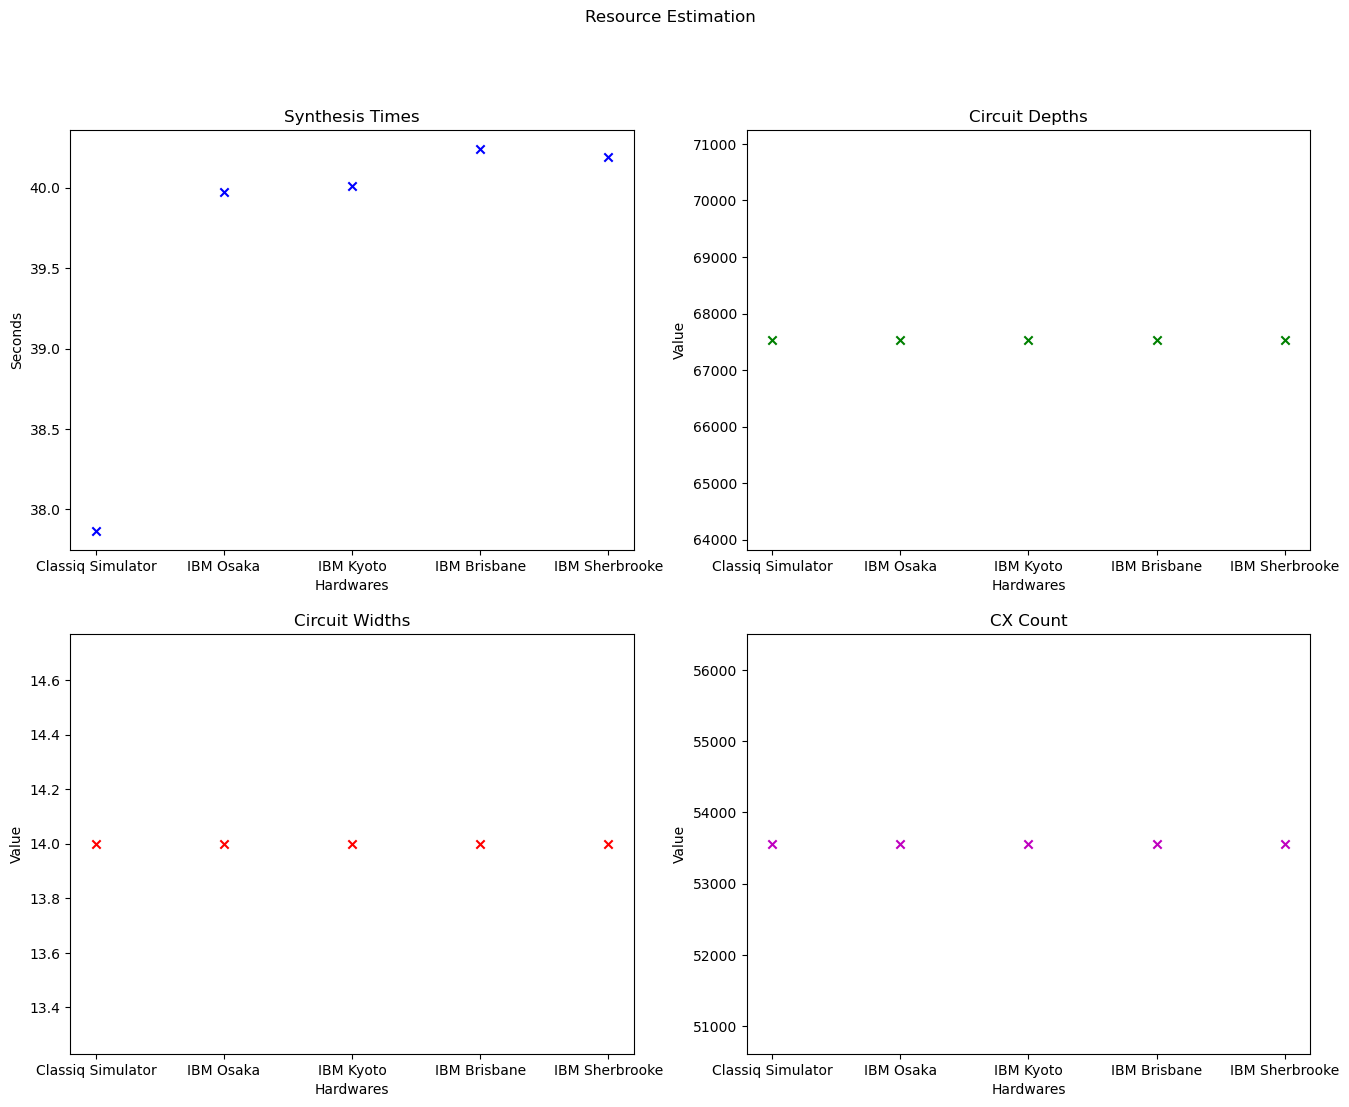

In [15]:
devices = ["Classiq Simulator"] + list(hardwares.keys())
syn_times = [syn_time] + [hardwares[i]["time"] for i in hardwares.keys()]
depths = [transp_depth] + [hardwares[i]["depth"] for i in hardwares.keys()]
widths = [transp_width] + [hardwares[i]["width"] for i in hardwares.keys()]
cxcount = [transp_cx] + [hardwares[i]["cx"] for i in hardwares.keys()]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[16,12])
fig.suptitle(r"Resource Estimation")
ax[0][0].set_title("Synthesis Times")
ax[0][0].set_ylabel("Seconds")
ax[0][0].set_xlabel("Hardwares")
ax[0][0].scatter(devices, syn_times, marker="x", c="b")
ax[0][1].set_title("Circuit Depths")
ax[0][1].set_ylabel("Value")
ax[0][1].set_xlabel("Hardwares")
ax[0][1].scatter(devices, depths, marker="x", c="g")
ax[1][0].set_title("Circuit Widths")
ax[1][0].set_ylabel("Value")
ax[1][0].set_xlabel("Hardwares")
ax[1][0].scatter(devices, widths, marker="x", c="r")
ax[1][1].set_title("CX Count")
ax[1][1].set_ylabel("Value")
ax[1][1].set_xlabel("Hardwares")
ax[1][1].scatter(devices, cxcount, marker="x", c="m")
ax[1][1].set_title("CX Count")

## Comparision of Hardware Resources
Necessary resources for all IBM Computers and also for `Classiq Simulator` seem same without any constraint and optimization. However, the synthesis time differs and `IBM Osaka` has the shorthest synthesis time. So, we choose `IBM Osaka` to make optimizations 

In [18]:
constraints_depth = Constraints(optimization_parameter=OptimizationParameter.DEPTH)

ibm_osaka = IBMBackendPreferences(
    backend_name="ibm_osaka",
    access_token="a413d92dafb1771ea3806b66493a2c5dfe195241eb753016f9fcd8d46ec80aeca1b6286cf9fa4d4c0f1f2420a7496c191fe0dd675e3cf5644142b95182964a63",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_osaka))
model_conts = set_constraints(model_pref, constraints_depth)
qprog_osaka_opt_depth = synthesize(model_conts)

In [19]:
print("IBM Osaka Depth Optimization")
syn_time_opt_depth = (QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_osaka_opt_depth).synthesis_duration.postprocessing)

transp_depth_opt_depth = QuantumProgram.parse_raw(qprog_osaka_opt_depth).transpiled_circuit.depth
transp_width_opt_depth = len(QuantumProgram.parse_raw(qprog_osaka_opt_depth).transpiled_circuit.logical_to_physical_input_qubit_map)
transp_cx_opt_depth = QuantumProgram.parse_raw(qprog_osaka_opt_depth).transpiled_circuit.count_ops["cx"]

print("Synthesis Time            : ", syn_time_opt_depth, "s")

print("Transpiled Circuit Depth  : ", transp_depth_opt_depth)
print("Transpiled Circuit Width  : ", transp_width_opt_depth)
print("Transpiled Circuit CX Gate: ", transp_cx_opt_depth)

IBM Osaka Depth Optimization
Synthesis Time            :  66.69157191595878 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561


In [20]:
constraints_width = Constraints(optimization_parameter=OptimizationParameter.WIDTH)

ibm_osaka = IBMBackendPreferences(
    backend_name="ibm_osaka",
    access_token="a413d92dafb1771ea3806b66493a2c5dfe195241eb753016f9fcd8d46ec80aeca1b6286cf9fa4d4c0f1f2420a7496c191fe0dd675e3cf5644142b95182964a63",
    provider=IBMBackendProvider(hub="ibm-q", group="open", Project="main")
)
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1000, backend_preferences=ibm_osaka))
model_conts = set_constraints(model_pref, constraints_depth)
qprog_osaka_opt_width = synthesize(model_conts)

In [21]:
print("IBM Osaka Width Optimization")
syn_time_opt_width = (QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.preprocessing + QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.solving + QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.conversion_to_circuit + QuantumProgram.parse_raw(qprog_osaka_opt_width).synthesis_duration.postprocessing)

transp_depth_opt_width = QuantumProgram.parse_raw(qprog_osaka_opt_width).transpiled_circuit.depth
transp_width_opt_width = QuantumProgram.parse_raw(qprog_osaka_opt_width).data.width
transp_cx_opt_width = QuantumProgram.parse_raw(qprog_osaka_opt_width).transpiled_circuit.count_ops["cx"]

print("Synthesis Time            : ", syn_time_opt_width, "s")

print("Transpiled Circuit Depth  : ", transp_depth_opt_width)
print("Transpiled Circuit Width  : ", transp_width_opt_width)
print("Transpiled Circuit CX Gate: ", transp_cx_opt_width)

IBM Osaka Width Optimization
Synthesis Time            :  67.00504704401828 s
Transpiled Circuit Depth  :  67537
Transpiled Circuit Width  :  14
Transpiled Circuit CX Gate:  53561


## Change the Evolution Method to Qubitization

`suzuki_trotter` does not get optimized well, so we can try another Qubitization method and see the optimization results. That is made in another notebook